In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [3]:
use_signal = [ i for i, m in enumerate(module.feynnet_signal_list) if m in module.signal_list ]
training_signal = [ i for i, m in enumerate(module.feynnet_signal_list) if m in module.full_signal_list ] 

In [4]:
signal = ObjIter([Tree(f, report=False, altfile='test_{base}') for f in tqdm(module.feynnet_signal_list)])

100%|██████████| 33/33 [01:20<00:00,  2.44s/it]


In [27]:
training_masses = [
    "MX_700_MY_300",
    "MX_700_MY_350",
    "MX_800_MY_300",
    "MX_800_MY_350",
    "MX_800_MY_400",
    "MX_900_MY_300",
    "MX_900_MY_350",
    "MX_900_MY_400",
    "MX_1000_MY_300",
    "MX_1000_MY_350",
    "MX_1000_MY_400",
    "MX_1000_MY_450",
]

training_signal = [ i for i, m in enumerate(signal) if m.sample in training_masses ]

In [8]:
def get_eff(t):
    cutflows = t.cutflow

    cutflow = sum( cutflow.histo for cutflow in cutflows )

    efficiency = cutflow/cutflow[0]

    return efficiency[-1]

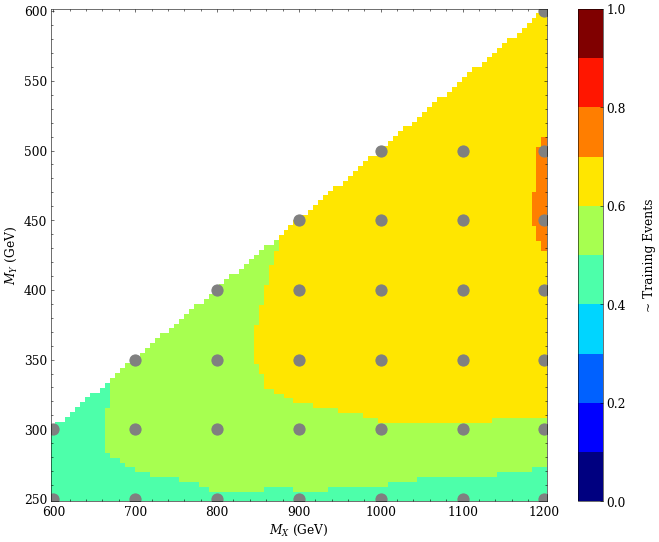

In [13]:
fig, ax = study.get_figax(size=(10,8))

study.mxmy_phase(
    signal,
    label=signal.mass.list,
    zlabel='~ Training Events',
    # efficiency=True,

    f_var=get_eff,
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    # zlim=np.linspace(3,6,11),
    zlim=np.linspace(0,1,11),

    figax=(fig,ax)
)

# graph_array(training_mx, training_my, figax=(fig,ax), g_color='red', g_ls='none', xlim=None, ylim=None)



In [14]:
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='test_{base}')])


100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


In [15]:
model = eightb.models.feynnet_sig_innersig
(signal + bkg).apply( lambda t : eightb.load_yy_quadh_ranker(t, model.storage), report=True )

100%|██████████| 34/34 [15:43<00:00, 27.76s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [7]:
# def fully_reconstructed(t):
#     h_b_ids = [ t[f'{quark}_signalId'] // 2 for quark in eightb.quarklist ]
#     y_h_ids = [ ak.where(h_b1_id == h_b2_id, h_b1_id, -1) // 2 for h_b1_id, h_b2_id in zip(h_b_ids[::2], h_b_ids[1::2]) ]
#     y1_id, y2_id = [ ak.where(y_h1_id == y_h2_id, y_h1_id, -1) // 2 for y_h1_id, y_h2_id in zip(y_h_ids[::2], y_h_ids[1::2]) ]
#     reco_id = ak.where(y1_id == y2_id, y1_id, -1)
#     t.extend(
#         reco_id = reco_id
#     )
# (signal).apply(fully_reconstructed)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]

In [16]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))
partial_signal = signal.apply(EventFilter('partial_eightb', filter=lambda t : t.nfound_select< 8))

In [17]:
unique_mx = np.unique(eightb_signal.mx.npy)
unique_my = np.unique(eightb_signal.my.npy)

In [18]:
def n_higgs_reco(t):
    return ak.sum(t.higgs_signalId > -1, axis=1)

100%|██████████| 1/1 [00:04<00:00,  4.58s/it]

x_mean=16.000
x_std=9.522
x_min=0.000
x_max=32.000
y_mean=0.299
y_std=0.262
y_min=0.000
y_max=0.804
x_sum=528.000
y_sum=9.871
area=9.869
ndf=33.000


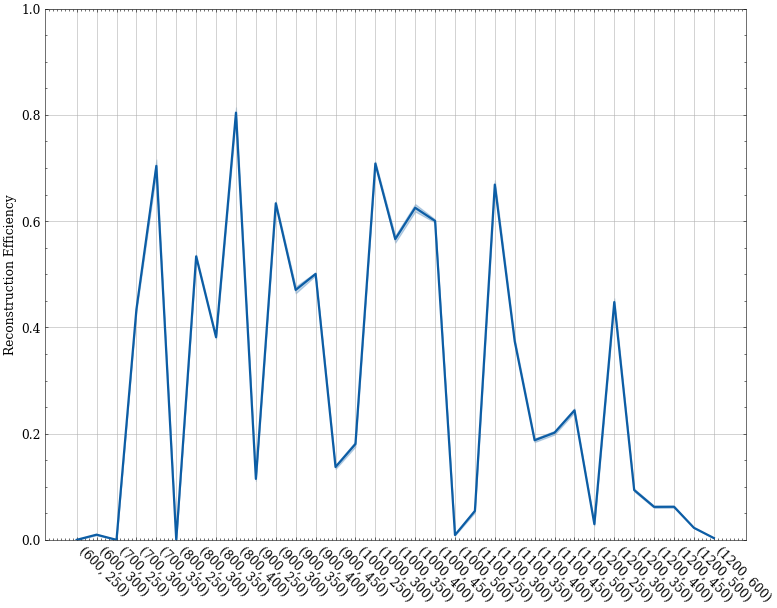

In [19]:
fig, ax = study.get_figax(size=(10,8))

study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
    g_ylim=(0,1),
    # g_g_label=f'MY={my}',
    # g_xlabel='MX',
    g_legend=True,
    figax=(fig,ax)
)

In [20]:
from utils.ak_tools import ak_argavg

In [21]:
eightb_signal_eff = eightb_signal.apply( lambda t : ak.mean(t.reco_id == 0) ).npy
extrema_signal = [eightb_signal_eff .argmin(), ak_argavg(eightb_signal_eff), eightb_signal_eff.argmax()]
eightb_signal_eff[extrema_signal]

array([2.97353553e-04, 2.43913889e-01, 8.04182746e-01])

In [73]:
extrema_signal

[7, 30, 26]

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


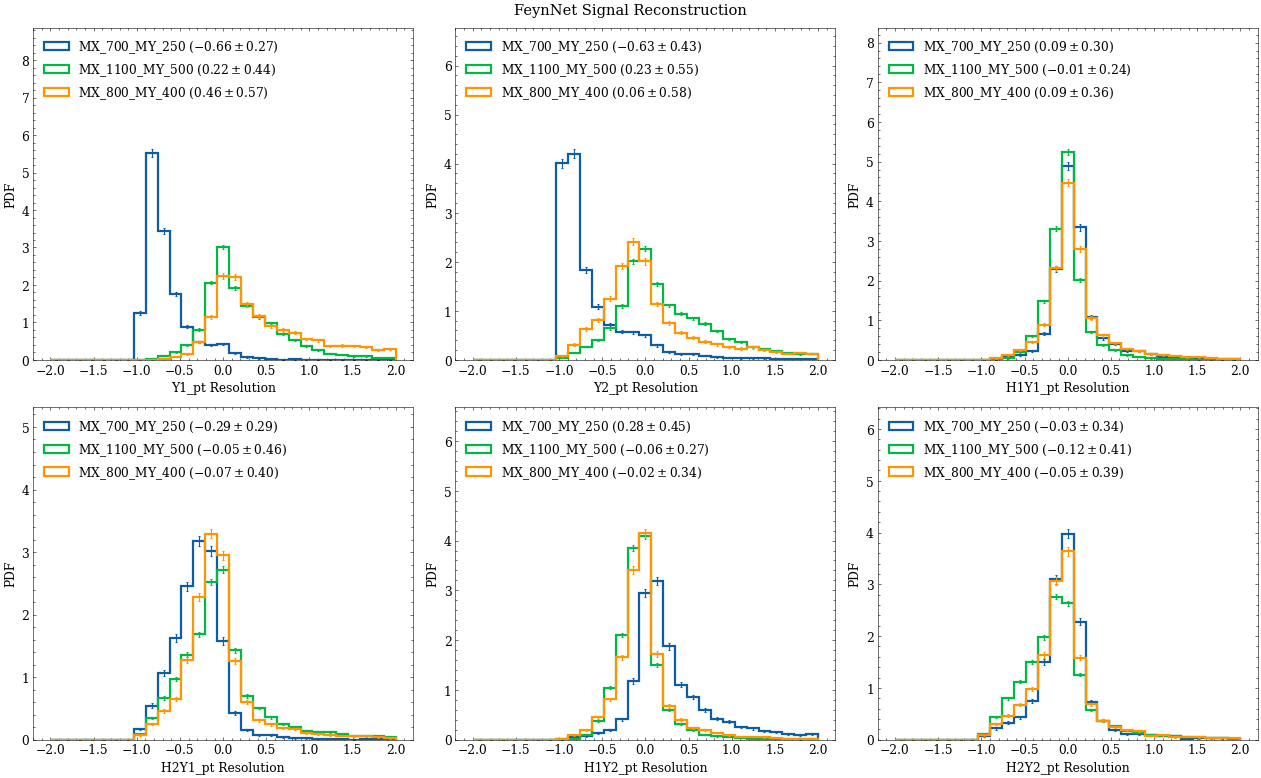

In [22]:
class gen_res(ObjTransform):
    def __init__(self, kin):
        self.kin = kin
    @property
    def xlabel(self): return f'{self.kin} Resolution'
    @property
    def bins(self): return (-2,2,30)
    def __call__(self, t):
        if self.kin is None: return
        return (t[self.kin]-t[f'gen_{self.kin}'])/t[f'gen_{self.kin}']

study.quick(
    eightb_signal[extrema_signal],
    legend=True,
    h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    varlist=[ gen_res(f'{res}_pt') for res in ['Y1','Y2','H1Y1','H2Y1','H1Y2','H2Y2']],
    suptitle='FeynNet Signal Reconstruction',
    h_restrict=True,
    lumi=None,
    density=True,
)

(<Figure size 800x640 with 2 Axes>,
 <AxesSubplot:label="['(600, 250)', '(600, 300)', '(700, 250)', '(700, 300)', '(700, 350)', '(800, 250)', '(800, 300)', '(800, 350)', '(800, 400)', '(900, 250)', '(900, 300)', '(900, 350)', '(900, 400)', '(900, 450)', '(1000, 250)', '(1000, 300)', '(1000, 350)', '(1000, 400)', '(1000, 450)', '(1000, 500)', '(1100, 250)', '(1100, 300)', '(1100, 350)', '(1100, 400)', '(1100, 450)', '(1100, 500)', '(1200, 250)', '(1200, 300)', '(1200, 350)', '(1200, 400)', '(1200, 450)', '(1200, 500)', '(1200, 600)']">)

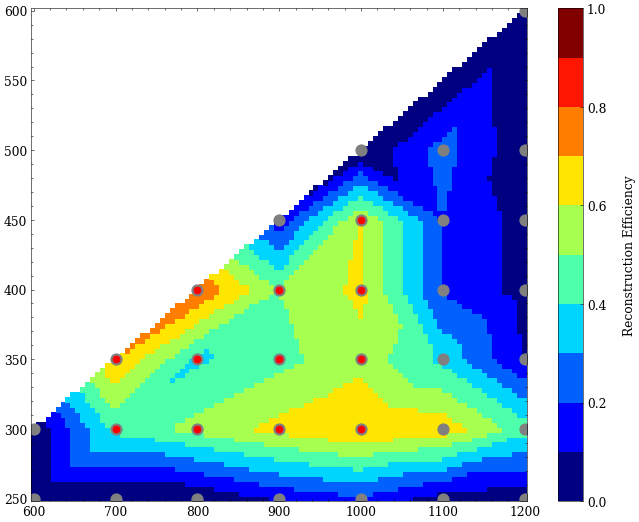

In [29]:
fig, ax = study.get_figax(size=(10,8))

study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    zlim=np.linspace(0,1,11),

    figax=(fig,ax)
)

training_mx = eightb_signal[training_signal].mx
training_my = eightb_signal[training_signal].my

graph_array(training_mx, training_my, figax=(fig,ax), g_color='red', g_ls='none', xlim=None, ylim=None)



100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


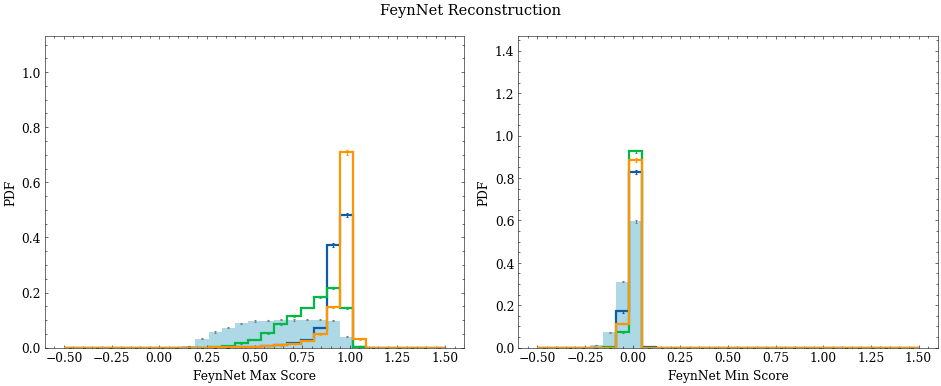

In [24]:
study.quick(
    eightb_signal[extrema_signal]+bkg,
    # legend=True,
    h_label_stat=None,
    varlist=['yy_quadh_score','yy_quadh_minscore'],
    xlabels=['FeynNet Max Score','FeynNet Min Score'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

In [25]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='Leading Y Boson Mass (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='Subleading Y Boson Mass (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Subleading Higgs Boson Mass (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 8/8 [00:01<00:00,  6.54it/s]


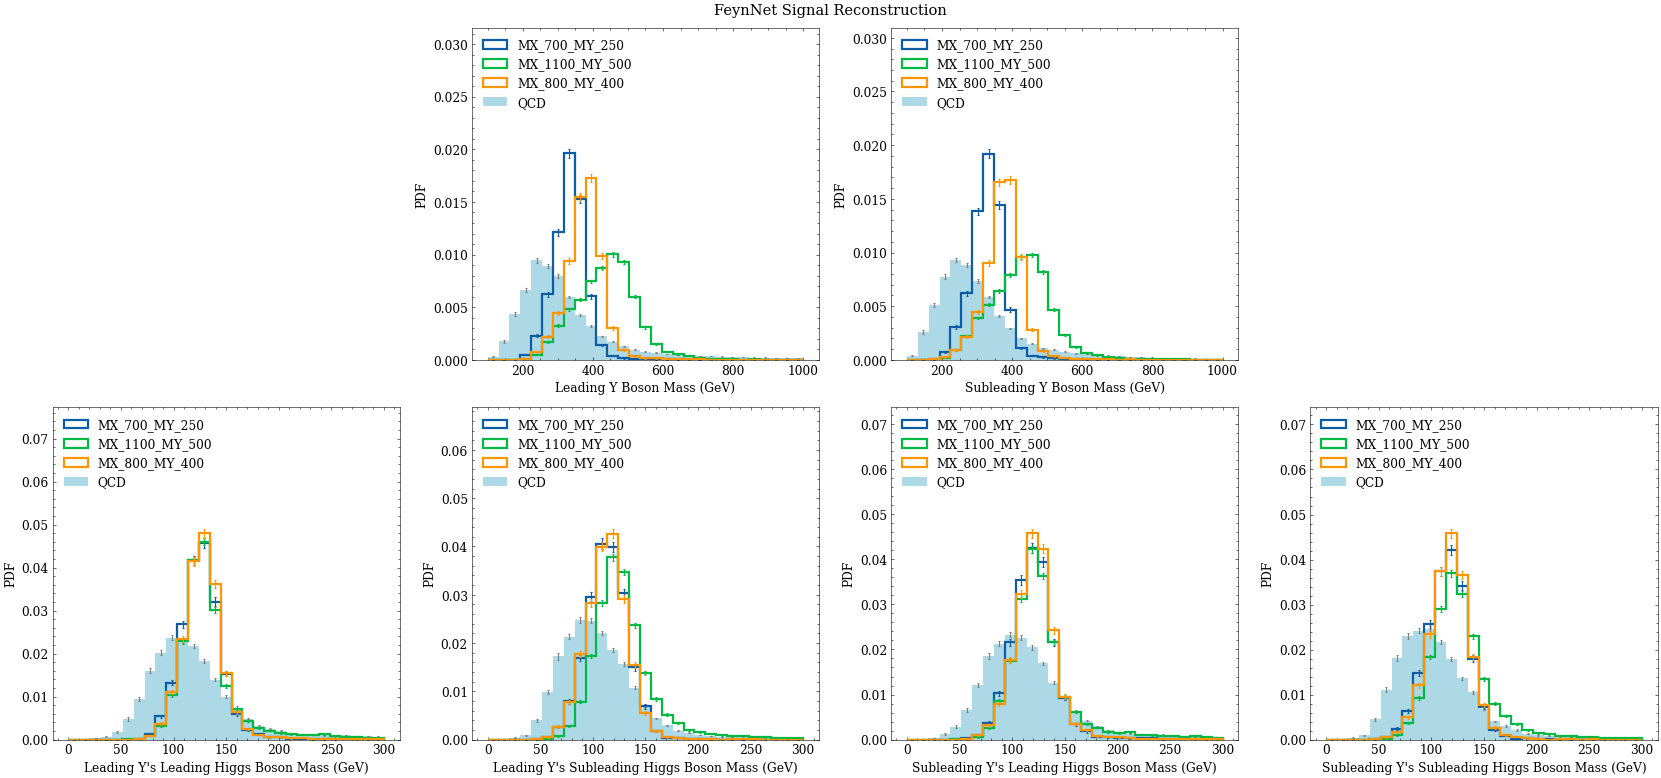

In [26]:
study.quick(
    eightb_signal[extrema_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=[None,'Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

In [36]:
eightb_signal.apply(lambda t : t.extend(norm_scale=1/(len(t) * t.scale)))
bkg.apply(lambda t : t.extend(norm_scale=ak.ones_like(t.scale)))


[None]

100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


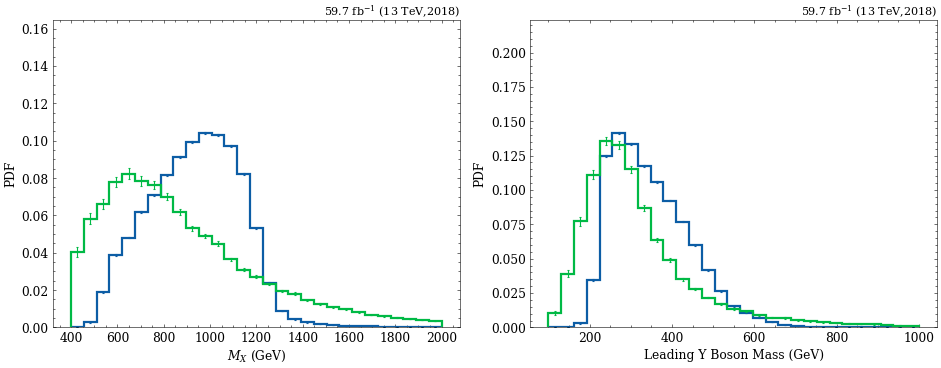

In [37]:
study.quick_region(
    eightb_signal,bkg,
    scale=lambda t : t.norm_scale,
    varlist=['X_m','Y1_m'],
    efficiency=True,

)